In [60]:
import numpy as np
import random

In [61]:
# Parameters
n = 5  # Grid size n x n
actions = ['up', 'right', 'down', 'left']  # Actions the agent can take
action_space = len(actions) # = 4

In [62]:
# Initialize Q-table: (agent_row, agent_col, package_row, package_col, carrying_flag, action) 
np.random.seed(222) # 222
q_values = np.random.rand(n, n, n, n, 2, action_space)

In [63]:
# Rewards
delivery_reward = 50  
move_reward = -1  
pickup_reward = 20 

In [64]:
# Define the target location (B)
B = (n - 1, n - 1)

In [65]:
# Function to check if the state is terminal (i.e., package delivered)
def is_terminal_state(agent_row, agent_col, carrying):
    return (agent_row, agent_col) == B and carrying

In [66]:
# Function to choose a random, non-terminal starting location for the agent and package
def get_starting_locations():
    agent_row = np.random.randint(n)
    agent_col = np.random.randint(n)
    package_row = np.random.randint(n)
    package_col = np.random.randint(n)
   # Needed?
    while (agent_row, agent_col) == B or (package_row, package_col) == B:
        agent_row = np.random.randint(n)
        package_row = np.random.randint(n)
        package_col = np.random.randint(n)
    return agent_row, agent_col, package_row, package_col

In [67]:
# Epsilon-greedy algorithm for choosing the next action
def get_next_action(agent_row, agent_col, package_row, package_col, carrying, epsilon):
    if np.random.random() < epsilon:
        return np.argmax(q_values[agent_row, agent_col, package_row, package_col, carrying])
    else:
        return np.random.randint(action_space)

In [68]:
# Function to get the next location based on the chosen action
def get_next_location(agent_row, agent_col, action_index):
    new_row, new_col = agent_row, agent_col
    if actions[action_index] == 'up' and agent_row > 0:
        new_row -= 1
    elif actions[action_index] == 'right' and agent_col < n - 1:
        new_col += 1
    elif actions[action_index] == 'down' and agent_row < n - 1:
        new_row += 1
    elif actions[action_index] == 'left' and agent_col > 0:
        new_col -= 1
    return new_row, new_col

In [69]:
# Function to update the Q-values during training
#alpha - learning_rate, gamma - discount_factor
def update_q_values(old_state, action_index, reward, new_state, learning_rate, discount_factor):
    old_q_value = q_values[old_state][action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[new_state])) - old_q_value
    q_values[old_state][action_index] = old_q_value + (learning_rate * temporal_difference)

In [70]:
# Training parameters
epsilon = 0.9  # Epsilon for epsilon-greedy strategy
discount_factor = 0.9  # Discount factor for future rewards
learning_rate = 0.15  # Learning rate
num_episodes = 20000  # Number of training episodes
max_steps_per_episode = 100  # Limit the steps per episode

In [71]:
import matplotlib.pyplot as plt

success_rates = []
episode_lengths = []
pickup_completion_rates = []
delivery_completion_rates = []
state_visit_counts = np.zeros((n, n))  # Adjust grid size as needed

# Additional variables
total_successes = 0
total_pickups = 0
total_deliveries = 0
q_value_diffs = []  # For tracking Q-value convergence

In [72]:
# Training loop
for episode in range(num_episodes):
    # Initialize starting locations
    agent_row, agent_col, package_row, package_col = get_starting_locations()
    carrying = 0  # Agent starts without carrying the package
    
    episode_reward = 0  # Track cumulative reward for this episode
    steps = 0
    
    old_q_values = np.copy(q_values)
    
    for step in range(max_steps_per_episode):
        # Choose action
        action_index = get_next_action(agent_row, agent_col, package_row, package_col, carrying, epsilon)
        
        # Get next location
        new_agent_row, new_agent_col = get_next_location(agent_row, agent_col, action_index)
        
        # Determine the reward and update carrying status
        if (new_agent_row, new_agent_col) == (package_row, package_col) and not carrying:
            reward = pickup_reward
            total_pickups += 1
            carrying = 1  # Now the agent is carrying the package
        elif (new_agent_row, new_agent_col) == B and carrying:
            reward = delivery_reward
            total_deliveries += 1
        else:
            reward = move_reward
        
        # Update Q-values
        old_state = (agent_row, agent_col, package_row, package_col, carrying)
        new_state = (new_agent_row, new_agent_col, package_row, package_col, carrying)
        update_q_values(old_state, action_index, reward, new_state, learning_rate, discount_factor)
        
        episode_reward += reward
        state_visit_counts[agent_row, agent_col] += 1
            
        steps += 1
        
        # Transition to the new state
        agent_row, agent_col = new_agent_row, new_agent_col
        
        # Check if the task is complete
        if is_terminal_state(agent_row, agent_col, carrying):
            total_successes += 1
            break
            
    success_rate = total_successes / (episode + 1)
    success_rates.append(success_rate)
    episode_lengths.append(steps)
    
    # Task completion rates
    pickup_rate = total_pickups / (episode + 1)
    delivery_rate = total_deliveries / (episode + 1)
    pickup_completion_rates.append(pickup_rate)
    delivery_completion_rates.append(delivery_rate)
    
    # Q-value convergence
    q_value_diff = np.abs(q_values - old_q_values).sum()
    q_value_diffs.append(q_value_diff)
    
    

print('Training complete!')

Training complete!


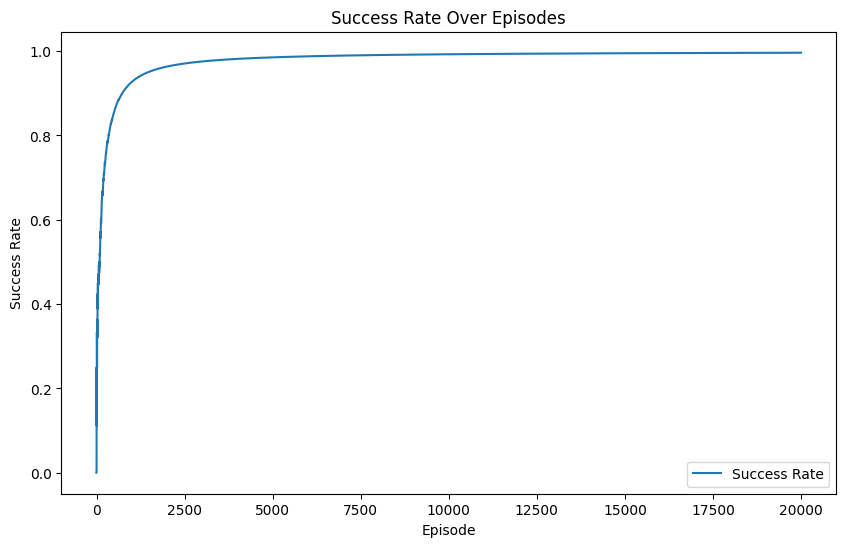

In [73]:
# Success Rate
plt.figure(figsize=(10, 6))
plt.plot(success_rates, label="Success Rate")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Success Rate Over Episodes")
plt.legend()
plt.show()

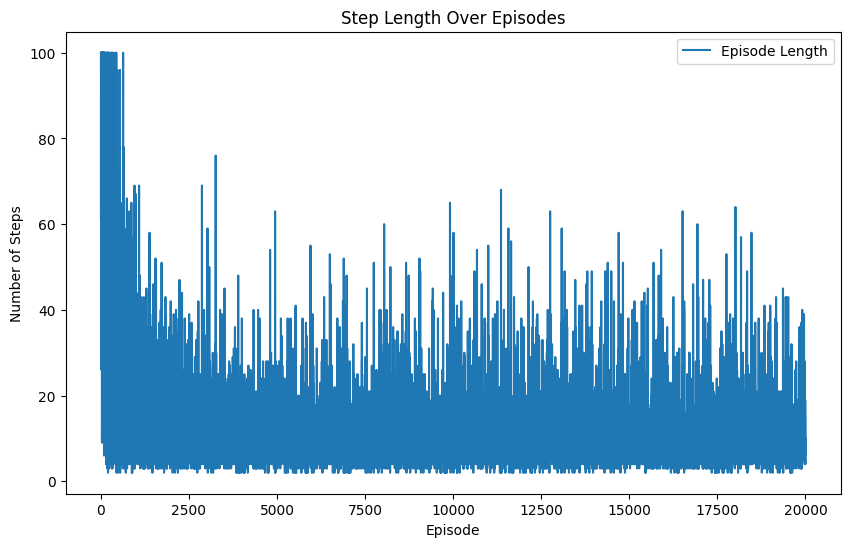

In [74]:
# Episode Length
plt.figure(figsize=(10, 6))
plt.plot(episode_lengths, label="Episode Length")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")
plt.title("Step Length Over Episodes")
plt.legend()
plt.show()

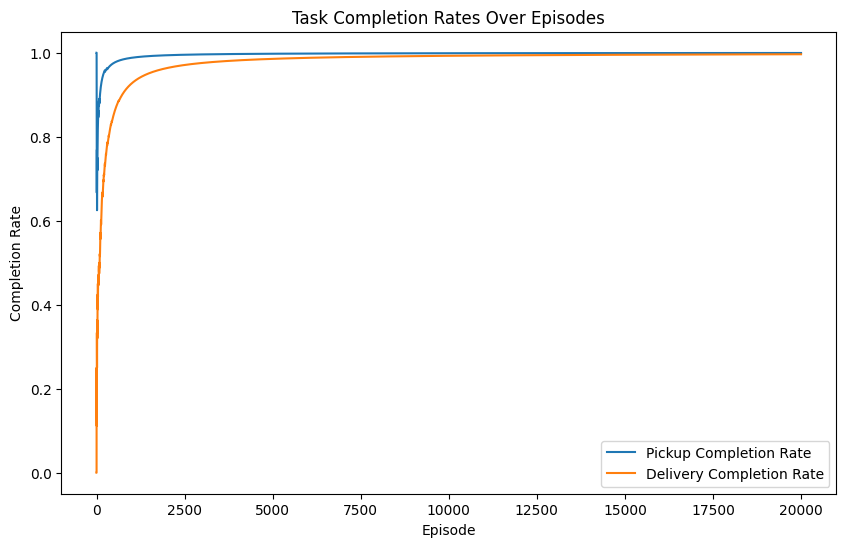

In [75]:
# Task Completion Rates
plt.figure(figsize=(10, 6))
plt.plot(pickup_completion_rates, label="Pickup Completion Rate")
plt.plot(delivery_completion_rates, label="Delivery Completion Rate")
plt.xlabel("Episode")
plt.ylabel("Completion Rate")
plt.title("Task Completion Rates Over Episodes")
plt.legend()
plt.show()

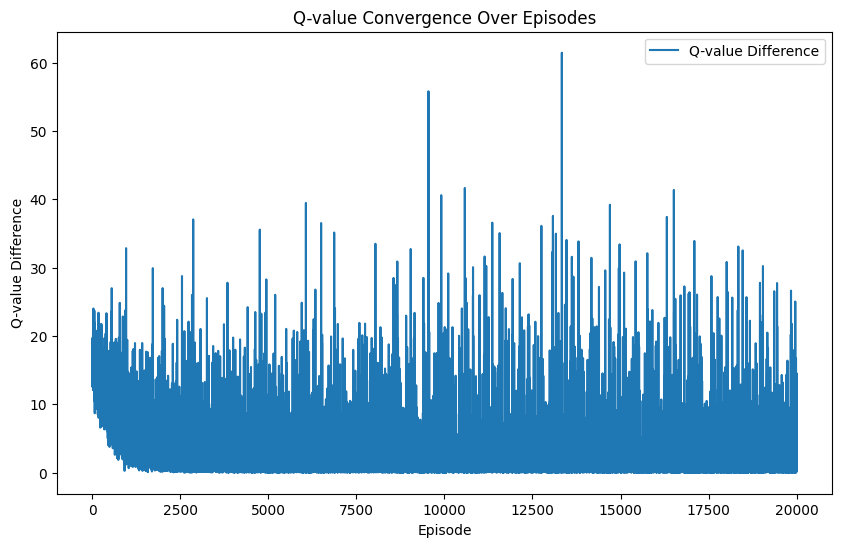

In [76]:
# Q-value Convergence
plt.figure(figsize=(10, 6))
plt.plot(q_value_diffs, label="Q-value Difference")
plt.xlabel("Episode")
plt.ylabel("Q-value Difference")
plt.title("Q-value Convergence Over Episodes")
plt.legend()
plt.show()

In [86]:
import networkx as nx

# Define a heuristic function (e.g., Manhattan distance)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


# Test the agent's performance after training
def test_agent(num_tests=1000):
    success_count = 0
    # Create a graph
    G = nx.grid_2d_graph(n, n)  # 5x5 grid
    opt = 0
    for _ in range(num_tests):
        agent_row, agent_col, package_row, package_col = get_starting_locations()
        start = (agent_row,agent_col)
        package = (package_row, package_col)
        goal = B
        opt_path_pkg = nx.astar_path(G, start, package, heuristic=heuristic)
        opt_path_goal = nx.astar_path(G, package, goal, heuristic=heuristic)
        carrying = 0
        path = [(agent_row, agent_col)]
        for step in range(max_steps_per_episode):
            action_index = get_next_action(agent_row, agent_col, package_row, package_col, carrying, 1.0)
            agent_row, agent_col = get_next_location(agent_row, agent_col, action_index)
            path.append((agent_row, agent_col))
            if (agent_row, agent_col) == (package_row, package_col) and not carrying:
                carrying = 1
            if is_terminal_state(agent_row, agent_col, carrying):
                success_count += 1
                print('Success')
                break
        print(f'Path taken by agent for package location: {(package_row, package_col)} - ')
        print(path)
        
        if len(path) == len(opt_path_pkg)+len(opt_path_goal)-1:
            opt+=1
    print(f'Success rate: {success_count}/{num_tests}')
    print(f'Optimal path rate: {opt}/{num_tests}')

test_agent()

Success
Path taken by agent for package location: (2, 2) - 
[(3, 1), (3, 2), (2, 2), (3, 2), (3, 3), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (1, 4) - 
[(1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (3, 3) - 
[(4, 2), (3, 2), (3, 3), (4, 3), (4, 4)]
Success
Path taken by agent for package location: (1, 0) - 
[(4, 1), (4, 0), (3, 0), (2, 0), (1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4)]
Success
Path taken by agent for package location: (1, 2) - 
[(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (4, 3) - 
[(4, 3), (4, 3), (4, 4)]
Path taken by agent for package location: (3, 0) - 
[(3, 1), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0), (2, 0), (3, 0

Optimal path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
